# Preparação e Exploração de Taxa de Câmbio 

Aqui é explorada a série temporal de taxa de câmbio entre YAN (moeda japonesa) e USD (dólar americano), sendo tratados: 
- Valores omissos (imputação/ interpolação)
- Mudança de escala temporal (diária -> mensal) para posterior combinação com outras séries temporais
## Importação e Exploração de Dados

Os dados são obtidos do FRED(Federal Reserve Economic Data) e a frequência temporal é explicitada como Business Days, através da letra B.

In [1]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from datetime import datetime 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Id do dataset no FRED
dataset = 'DEXJPUS'
start = datetime(2003,3, 1)
end = datetime(2023,3, 1)

exchange = web.DataReader(dataset, data_source = 'fred', start=start, end=end)
exchange.index.freq = 'B'
exchange.head(5)

,DEXJPUS
DATE,
2003-03-03,117.93
2003-03-04,117.96
2003-03-05,117.32
2003-03-06,117.22
2003-03-07,116.47


### Verificar valores nulos

Neste passo, confirma-se a utilização das datas como objeto DateTime, com frequência B (Business Days) e verifica-se a existência de valores nulos.

In [2]:
exchange = exchange.rename(columns={'DEXJPUS': 'Rate'})
exchange.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5218 entries, 2003-03-03 to 2023-03-01
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rate    5015 non-null   float64
dtypes: float64(1)
memory usage: 81.5 KB


### Verificar valores duplicados

Após a verificação de nulos, é feita uma verificação de registos duplicados

In [3]:
exchange[exchange.index.duplicated()]

,Rate
DATE,


Como não se verificam registos duplicados, não há necessidade da sua remoção.

### Visualização da Série Temporal

Neste passo, é representada a série temporal, para ver o seu comportamento. 
Não é aparente, tendência ou a existência de sazonalidade.

Text(0.5, 1.0, 'Taxa de Câmbio entre USD e YAN')

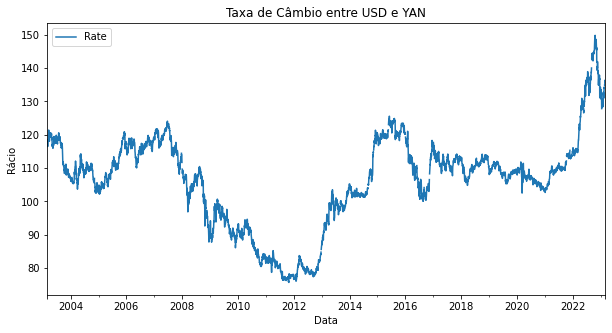

In [4]:
ax = exchange.plot(figsize=(10,5))
ax.set_xlabel('Data')
ax.set_ylabel('Rácio')
ax.set_title('Taxa de Câmbio entre USD e YAN') 

## Imputação / Interpolação de Valores
Como visto anteriormente no gráfico, e na tabela descritiva do _info()_, existem valores nulos, pelo que, neste passo são designados valores para os mesmos. De modo a escolher o método de imputação, para o qual os valores serão assumidos, foram testados atribuição por:

- Média 
- Interpolação Linear
- Valor seguinte

In [5]:
### impute missing values with different methods

## impute mean
exchange= exchange.assign(FillMean=exchange.Rate.fillna(exchange.Rate.mean()))

## linear interpolation
exchange = exchange.assign(InterpolateLinear=exchange.Rate.interpolate(method='linear'))

## impute with the next value 
exchange = exchange.assign(FillF=exchange.Rate.fillna(method='ffill'))

In [6]:
exchange

,Rate,FillMean,InterpolateLinear,FillF
DATE,,,,
2003-03-03,117.93,117.93,117.93,117.93
2003-03-04,117.96,117.96,117.96,117.96
2003-03-05,117.32,117.32,117.32,117.32
2003-03-06,117.22,117.22,117.22,117.22
2003-03-07,116.47,116.47,116.47,116.47
...,...,...,...,...
2023-02-23,134.80,134.80,134.80,134.80
2023-02-24,136.36,136.36,136.36,136.36
2023-02-27,136.18,136.18,136.18,136.18


In [7]:
exchange[exchange['Rate'].isna()]

,Rate,FillMean,InterpolateLinear,FillF
DATE,,,,
2003-05-26,NaN,106.362209,117.005,116.89
2003-07-04,NaN,106.362209,118.160,118.24
2003-09-01,NaN,106.362209,116.430,116.71
2003-10-13,NaN,106.362209,108.930,108.57
2003-11-11,NaN,106.362209,108.265,107.98
...,...,...,...,...
2022-11-24,NaN,106.362209,139.485,139.76
2022-12-26,NaN,106.362209,133.105,132.78
2023-01-02,NaN,106.362209,131.320,131.81


<Axes: xlabel='DATE'>

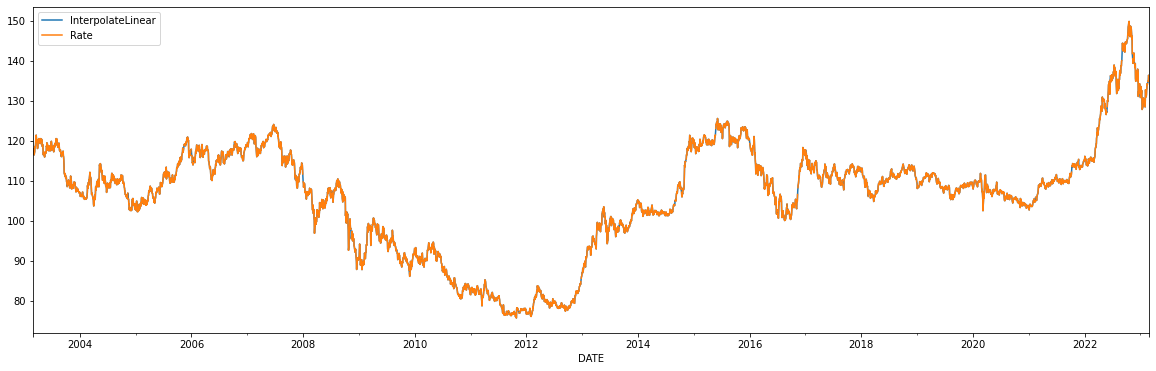

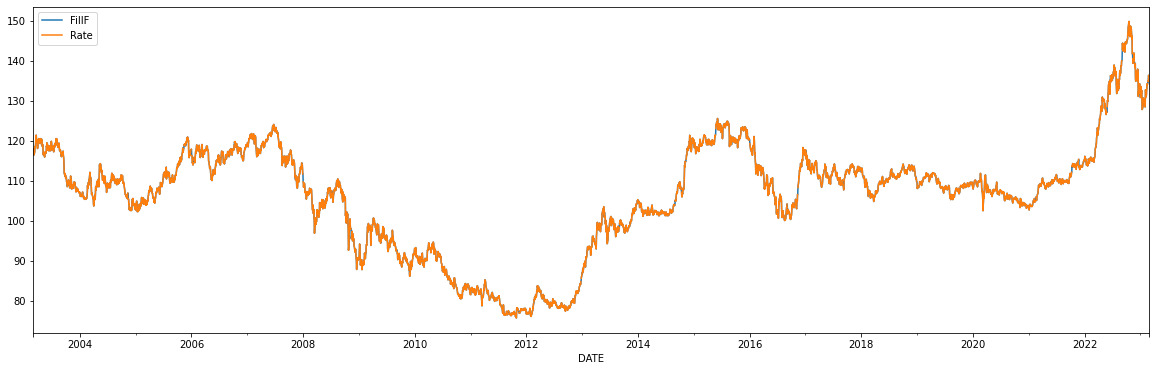

In [8]:
exchange[['InterpolateLinear','Rate']].plot(figsize=(20,6))
exchange[['FillF','Rate']].plot(figsize=(20,6))

### Escolha e atribuição de interpolação  

Dado que a série não tem média constante, a atribuição por média não terá uma boa representação dos valores em falta, pelo que faz sentido analisar apenas por interpolação linear e valor seguinte. 

Para comparar as 2 técnicas anteriormente mencionadas, foi representado o gráfico para ambas as interpolações, que demonstrou serem semelhantes, o que já seria esperado, pelos valores da tabela de rácios nulos, onde se viam valores próximos entre ambas as interpolações. 

Assim, como ambos se ajustam à série em mãos, utilizou-se a interpolação linear, pelo facto de ter sido utilizada nas restantes análises do grupo.


In [9]:
# Retain only the column with best interpolation
exchange = exchange.drop(columns=[col for col in exchange.columns if col != 'InterpolateLinear'])
exchange = exchange.rename(columns={'InterpolateLinear':'Rate'})

## Mudança de frequência temporal para Mensal

Com a série temporal já tratada (sem valores em falta ou duplicados), pode-se agora estabelecer a conversão de frequência diária para mensal, para efeitos de compatibilidade entre séries, como indicado no início do notebook.

In [10]:
exchange_month = exchange.resample(rule='MS').mean()
exchange_month.head()

,Rate
DATE,
2003-03-01,118.687143
2003-04-01,119.895000
2003-05-01,117.351591
2003-06-01,118.329048
2003-07-01,118.672609


### Visualização e Exploração da série em formato mensal

Pós alteração de escala temporal, são observados novamente, os gráficos de dados, junto com descrição estatística dos mesmos

Text(0.5, 1.0, 'Taxa de Câmbio entre USD e YAN')

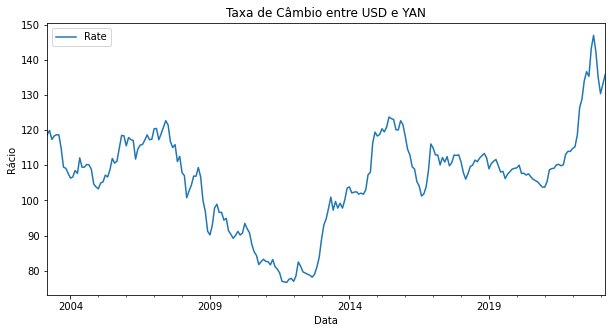

In [11]:
ax = exchange_month.plot(figsize=(10,5))
ax.set_xlabel('Data')
ax.set_ylabel('Rácio')
ax.set_title('Taxa de Câmbio entre USD e YAN') 

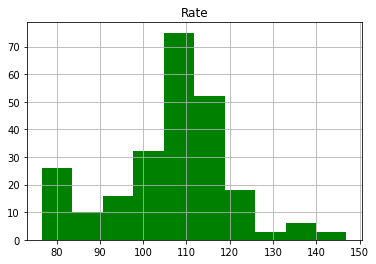

In [12]:
exchange_month.hist(color='green')
plt.show()

In [13]:
exchange_month.describe()

,Rate
count,241.000000
mean,106.496901
std,13.695248
min,76.646429
25%,100.145476
50%,108.747273
75%,114.828810
max,146.971429


In [14]:
exchange_month[exchange_month['Rate'] == exchange_month['Rate'].min()]

,Rate
DATE,
2011-10-01,76.646429


In [15]:
exchange_month[exchange_month['Rate'] == exchange_month['Rate'].max()]

,Rate
DATE,
2022-10-01,146.971429


## Guardar dados mensais

Com a imputação feita, e a conversão de frequência diária para mensal, os dados são, agora, armazenados em ficheiro para utilização em notebooks de previsão. 

In [29]:
exchange_month.to_csv('usd-yan.csv')

## Conjunto de Treino

Definiu-se em grupo, a utilização de separação dos dados em 90% treino / 10% teste, pelo que essa divisão é feita neste momento, antes de testar a estacionaridade.

Para este notebook, apenas é retido a parte de treino, dado não haver previsões para utilizar os dados de teste.



In [17]:
split = round(len(exchange)*0.9)
exch_train = exchange_month[0:split]

In [18]:
exch_train.head()

,Rate
DATE,
2003-03-01,118.687143
2003-04-01,119.895000
2003-05-01,117.351591
2003-06-01,118.329048
2003-07-01,118.672609


## Verificação das componentes de Tendência e Sazonalidade

De modo a analisar as componentes de tendência e sazonalidade, a fim de aferir a sua existência, é feita uma decomposição de sazonalidade.

<Axes: xlabel='DATE', ylabel='Resid'>

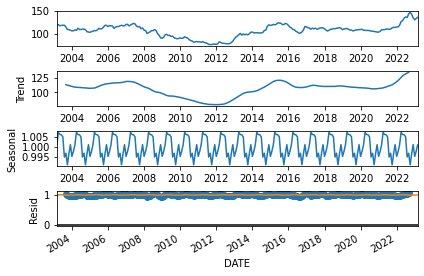

In [19]:
# proced with the time series decomposition
result = seasonal_decompose(exch_train, model='multiplicative')

# plot time series component
result.plot()

# plot only the seasonal component
result.seasonal.plot()

### Conclusões Gráficas

Através da decomposição, visualiza-se que para esta série, existe sazonalidade e não há uma tendência determinística, porém a média não é constante, o que nos leva a concluir, que não se trata de uma série estacionária.

### Estacionaridade

Com a decomposição anterior, e mesmo com a visualização gráfica, anterior, da série, é possível ter uma ideia sobre a estacionaridade da série temporal, porém, de uma forma analítica, é possível, também, analisar a estacionaridade através de testes de raiz unitária, neste caso é utilizado o ADFuller.

In [20]:
raw_test = adfuller(exch_train)
print("p-value =", raw_test[1])

if raw_test[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 0.6278327150284534
We do not reject the H0: non-stationary time series <-> we have a unit root


Como do teste de ADFuller, resultou um p-value > 0.05, conclui-se que a série não é estacionária. 

### ACF & PACF

Visualização do comportamento de Autocorrelação e Autocorrelação Parcial

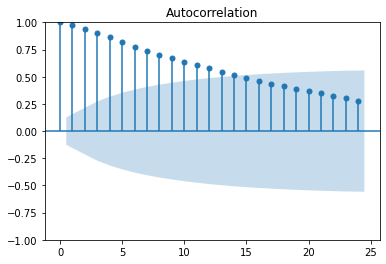

In [21]:
plot_acf(exch_train)

plt.show()

c:\Users\usr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


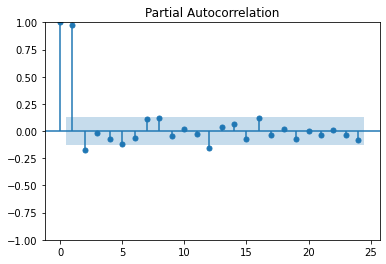

In [22]:
plot_pacf(exch_train)
plt.show()

A combinação de autocorrelação e autocorrelação parcial, leva-nos a concluir a existência de uma componente AR(Auto Regressiva), pelo decréscimo, aproximadamente exponencial, dos valores na autocorrelação, a tender para 0, juntamente de alguns picos significativos, na autocorrelação parcial.

## Diferenciação

Dado a série não ser estacionária, é necessário aplicar diferenciação, ao que se aplicaram: 12 lags para a sazonalidade, mais um para a média não constante.

<Axes: xlabel='DATE'>

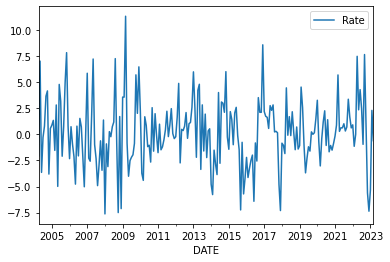

In [23]:
exch_train = exch_train.diff(12).diff().dropna()

exch_train.plot()

### Verificação de estacionaridade

Utilização de Adfuller, como aplicado na série original.

In [24]:
test2 = adfuller(exch_train)
print("p-value =", test2[1])

if test2[1]> 0.05:
    print("We do not reject the H0: non-stationary time series <-> we have a unit root")

p-value = 6.574560212794843e-10


Agora, com um p-value inferior a 0.05, já se conclui a estacionaridade da série.

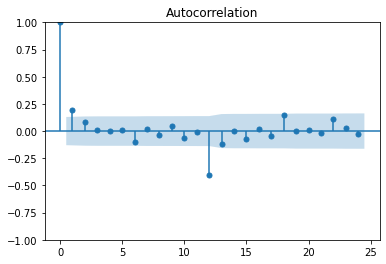

In [25]:
plot_acf(exch_train)
plt.show()

c:\Users\usr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


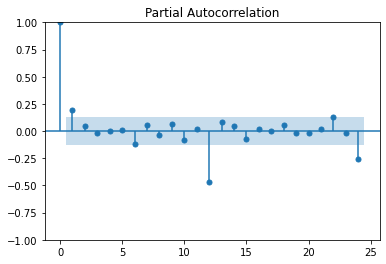

In [26]:
plot_pacf(exch_train)
plt.show()